In [1]:
import sys
sys.path.append('../../gears_misc/')

from gears import PertData, GEARS
import numpy as np
import pandas as pd
import torch
import scanpy as sc

%load_ext autoreload
%autoreload 2

Load data. We use norman as an example.

In [2]:
data_name = 'norman_umi'
model_name = 'gears_misc_umi_no_test'

In [3]:
from gears import PertData, GEARS

pert_data = PertData('/dfs/project/perturb-gnn/datasets/data')
pert_data.load(data_path = '/dfs/project/perturb-gnn/datasets/data/norman_umi')
pert_data.prepare_split(split = 'no_test', seed = 1)
pert_data.get_dataloader(batch_size = 32, test_batch_size = 128)

Found local copy...
These perturbations are not in the GO graph and is thus not able to make prediction for...
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Done!
Creating dataloaders....
Done!


Create a model object; if you use [wandb](https://wandb.ai), you can easily track model training and evaluation by setting `weight_bias_track` to true, and specify the `proj_name` and `exp_name` that you like.

In [4]:
gears_model = GEARS(pert_data, device = 'cuda:7', 
                        weight_bias_track = False, 
                        proj_name = 'gears', 
                        exp_name = model_name)
gears_model.load_pretrained('./model_ckpt/'+model_name)

In [5]:
def get_reverse(perts):
    return [t.split('+')[-1]+'+'+t.split('+')[0] for t in perts]

def remove_reverse(perts):
    return list(set(perts).difference(set(get_reverse(perts))))

def remove_duplicates_list(list_):
    import itertools
    list_.sort()
    return list(k for k,_ in itertools.groupby(list_))

In [6]:
norman_adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/data/'+data_name+'/perturb_processed.h5ad')

genes_of_interest = set([c.strip('+ctrl') for c in norman_adata.obs['condition'] 
                         if ('ctrl+' in c) or ('+ctrl' in c)])
genes_of_interest = [g for g in genes_of_interest if g in list(pert_data.pert_names)]


all_possible_combos = []

for g1 in genes_of_interest:
    for g2 in genes_of_interest:
        if g1==g2:
            continue
        all_possible_combos.append(sorted([g1,g2]))
        
all_possible_combos = remove_duplicates_list(all_possible_combos)

In [33]:
#from pertnet.utils import detect_non_additive
def detect_non_additive3(pertnet_model, combo, uncertainty=True, 
                        k=20):
    """
        Given a combination return differential expression over control
        for most non-additively expressed genes
    """
    result = pertnet_model.predict([[combo[0]], [combo[1]], combo])
    if uncertainty:
        result = result[0]     
    ctrl_mean = np.squeeze(np.asarray(pertnet_model.ctrl_adata.X.mean(0)))
    de_result = {p:(result[p] -ctrl_mean) for p in result}

    additive_result = de_result[combo[0]] + de_result[combo[1]]
    non_additive_effect = np.abs(de_result['_'.join(combo)] - additive_result)
    non_additive_genes = np.argsort(non_additive_effect)[-k:]
    gi_result = {'additive': additive_result[non_additive_genes],
        '_'.join(combo): de_result['_'.join(combo)][non_additive_genes],
        combo[0]: de_result[combo[0]][non_additive_genes],
        combo[1]: de_result[combo[1]][non_additive_genes],
    }
    gi_result = pd.DataFrame(gi_result).T
    gi_result.columns = pertnet_model.adata.var.gene_name.values[non_additive_genes]
    
    return gi_result

def add_bar_group(plot_df, x, combo, gene, ax):
    x_g,y_g = combo[0], combo[1]
    
    n1 = plot_df.loc[x_g, gene]
    n2 = plot_df.loc[y_g, gene]

    pred = plot_df.loc['_'.join(combo), gene]
    
    ax.bar(x+1, n1, edgecolor='black', 
            linewidth=1.5, hatch="\\\\", color='goldenrod')
    ax.bar(x+1, n2, bottom=n1, edgecolor='black', 
            linewidth=1.5, color='goldenrod', hatch='//')
    ax.bar(x+2, pred, edgecolor='black', 
        linewidth=1, color='firebrick')
    
def add_bar_group_err(plot_df, x, combo, gene, ax, seen=2, 
                      combo_CIs=0, single_CIs_1=0, single_CIs_2=0, 
                      gears_CIs=0):
    x_g,y_g = combo[0], combo[1]
 
    n1 = plot_df.loc[x_g, gene]
    n2 = plot_df.loc[y_g, gene]

    pred = plot_df.loc['_'.join(combo), gene]

    ax.bar(x+1, n1, edgecolor='black', 
            linewidth=1.5, hatch="\\\\", color='goldenrod')

    if n1>0:
        if n2>0:
            n_ = n1
        if n2<0:
            n_ = 0
    else:
        if n2>0:
            n_ = 0
        if n2<0:
            n_ = n1       
    ax.bar(x+1, n2, bottom=n_, edgecolor='black', 
            linewidth=1.5, color='goldenrod', hatch='//')
    ax.bar(x+2, pred, edgecolor='black', 
        linewidth=1, color='firebrick')

    if n1>0:
        if n2>0:
            y_ = n1+n2
        if n2<0:
            y_ = n1
    else:
        if n2<0:
            y_ = n1+n2
        if n2>0:
            y_ = n2
    plt.errorbar(x=x+1, y=y_, yerr=np.abs(single_CIs_1)+np.abs(single_CIs_2), 
             color='black')
    plt.errorbar(x=x+2, y=pred, yerr=gears_CIs, 
             color='black')
    
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def get_CI(pert, genes):
    control_vals = adata[adata.obs['condition']=='ctrl'][:,list(genes)].X.toarray()
    control_vec = control_vals.mean(0)
    pred_vals = adata[adata.obs['condition']==pert][:,list(genes)].X

    corrected_pred = pred_vals.toarray() - control_vec
    
    CIs = []
    for col in range(corrected_pred.shape[1]):
        CIs.append(mean_confidence_interval(corrected_pred[:,col]))
    return CIs

def get_CI_perts(genes, n=300):
    ## Take several samples of size 300 from the control distribution
    ## Determine the 95% CI for these samples, this would be equivalent to the CI for the GEARS prediction
    ## Since the only souce of randomness is the control distribution
    
    control_vals = []
    ctrl_adata = adata[adata.obs['condition']=='ctrl']
    for itr in range(100):
        idxs = np.random.choice(ctrl_adata.obs.index, n)
        control_vals.append(ctrl_adata[idxs,list(genes)].X.toarray().mean(0))
    
    CIs = []
    control_vals = np.array(control_vals)
    for col in range(control_vals.shape[1]):
        CIs.append(mean_confidence_interval(control_vals[:,col]))
    return CIs
    
def plot_bar_group(plot_df, combo):
    fig = plt.figure(figsize=[10,4])
    ax = plt.gca()
    step = 4
    xticks = []
    xticklabels = []
    g1 = combo[0]
    g2 = combo[1]
    
    genes = list(plot_df.columns)
    combo_CIs = get_CI('+'.join(combo), genes=genes)
    single_CIs_1 = get_CI(get_single_name(g1, adata=adata), genes=genes)
    single_CIs_2 = get_CI(get_single_name(g2, adata=adata), genes=genes)
    gears_CIs = get_CI_perts(genes=list(plot_df.columns))

    for itr, gene in enumerate(plot_df.columns):
        #add_bar_group(plot_df, (itr*step), combo, gene, ax)
        add_bar_group_err(plot_df, (itr*step), combo, gene, ax, 
                      combo_CIs=combo_CIs[itr][1]-combo_CIs[itr][0],
                      single_CIs_1=single_CIs_1[itr][1] - single_CIs_1[itr][0],
                      single_CIs_2=single_CIs_2[itr][1] - single_CIs_2[itr][0],
                      gears_CIs = gears_CIs[itr][1] - gears_CIs[itr][0])
        xticks.append(itr*step+1)
        xticklabels.append(gene)

    plt.legend(['Additive ({})'.format(g1), 'Additive ({})'.format(g2), 'GEARS'], 
              ncol=2, loc='upper left')

    plt.ylabel('Change in gene expression')
    #plt.ylim([-1.4, 1.7])
    plt.xlabel('Gene')
    plt.title('Change in gene expression after perturbing '+ '_'.join(combo))

    plt.xticks(xticks, xticklabels)

    ax.axhline(y=0, color='k')
    
    return xticklabels

def get_single_name(g, adata):
    name = g+'+ctrl'
    if name in adata.obs.condition.values:
        return name
    else:
        return 'ctrl+'+g

In [8]:
import matplotlib 
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [9]:
from gears.inference import GIs

In [12]:
adata = sc.read_h5ad('/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hi_umi+hvg.h5ad')
adata.var = adata.var.set_index('gene_name')

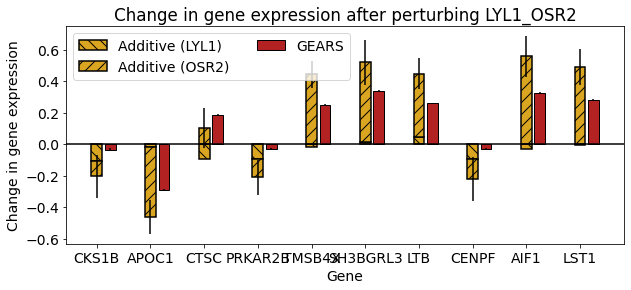

In [39]:
combo = ['LYL1','OSR2']
plot_df = detect_non_additive3(gears_model, combo, uncertainty=False, k=10)
_ = plot_bar_group(plot_df, combo)
#plt.ylim([-0.4,1.0])
ax = plt.gca()
ax.grid(False)

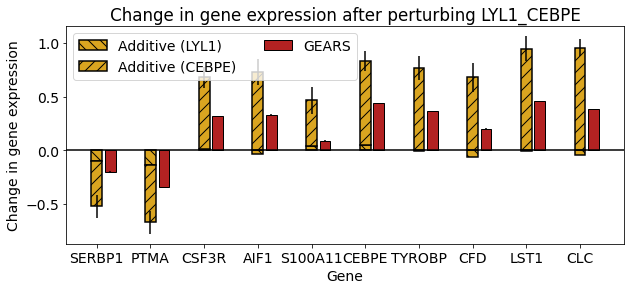

In [40]:
combo = ['LYL1','CEBPE']
plot_df = detect_non_additive3(gears_model, combo, uncertainty=False, k=10)
_ = plot_bar_group(plot_df, combo)
#plt.ylim([-0.1,1.1])
ax = plt.gca()
ax.grid(False)